### Importações gerais

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import layers

### Importando os dados

In [64]:
data = pd.read_csv('./data/data.csv')
x = data.drop(columns=['PassengerId', 'Name', 'Survived'])
y = data['Survived']

### Lidando com dados faltantes

In [65]:
# Coluna 'Age'
ageAverage = round(x.Age.mean())
x.fillna({'Age': ageAverage}, inplace=True)

# Coluna 'Embarked'
moreEmbarked = x.Embarked.value_counts().keys()[0]
x.fillna({'Embarked': moreEmbarked}, inplace=True)

# Coluna 'Fare'
fareMedia = round(x.Fare.mean())
x.fillna({'Fare': fareMedia}, inplace=True)

### Aplicando LabelEncodet

In [66]:
labEncoder = preprocessing.LabelEncoder()

x['Ticket'] = labEncoder.fit_transform(x['Ticket'])
x['Cabin'] = labEncoder.fit_transform(x['Cabin'])
x['Sex'] = labEncoder.fit_transform(x['Sex'])

### Aplicando OneHotEncoder

In [67]:
onHotEncoder = preprocessing.OneHotEncoder()

embarked_infos = onHotEncoder.fit_transform(x.Embarked.values.reshape(-1, 1)).toarray()

df_embarked_OneHot = pd.DataFrame(embarked_infos, columns = ['Embarked_C', 'Embarked_Q', 'Embarked_S'])

x = x.reset_index(drop=True)
x = x.join(df_embarked_OneHot)
x = x.drop(['Embarked'], axis=1)

### Dividindo os dados

In [68]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Normalizando os dados

In [69]:
normalizacao = StandardScaler()
normalizacao.fit(X_train)

X_train_std = normalizacao.transform(X_train)
X_test_std = normalizacao.transform(X_test)

### Avaliando a rede MLP

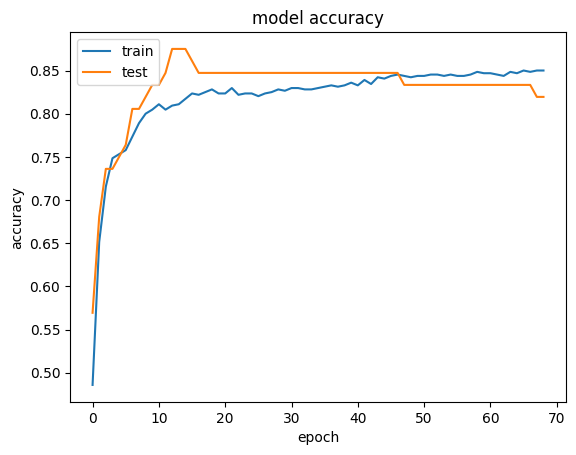

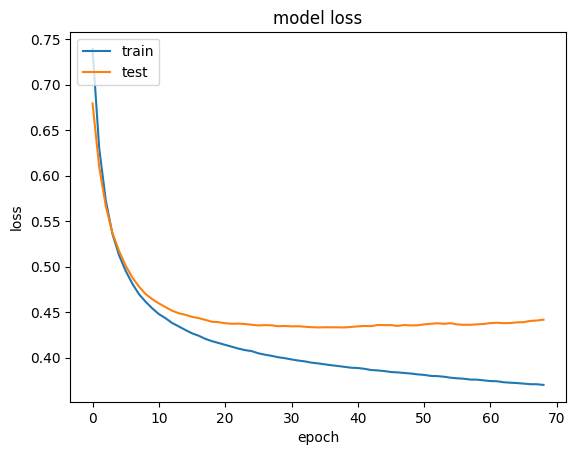

Camadas ocultas: 1
N° neurônios: 16




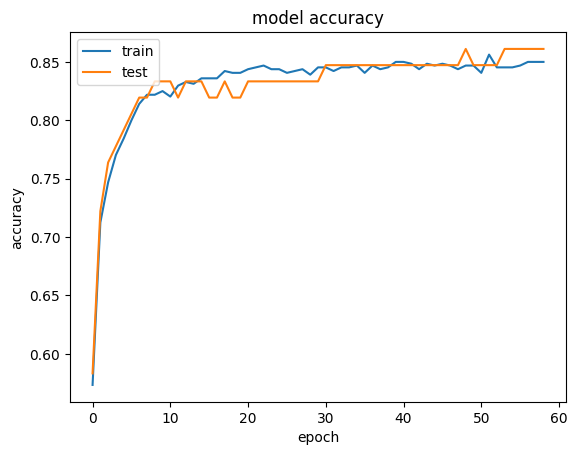

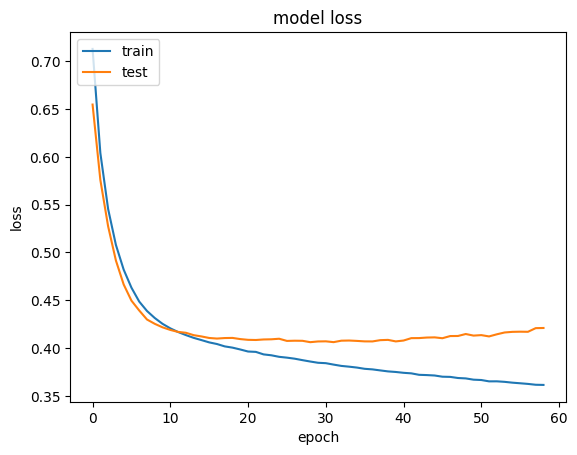

Camadas ocultas: 1
N° neurônios: 32




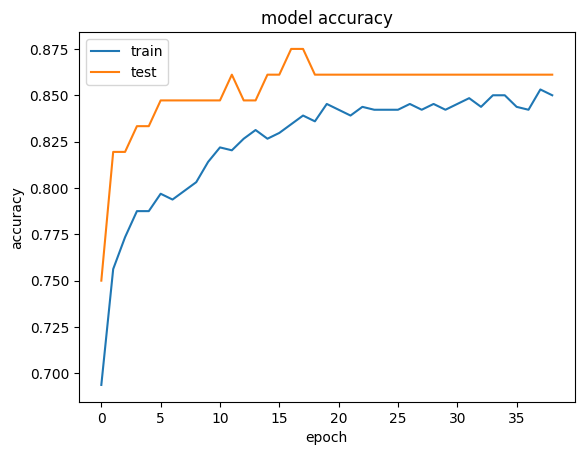

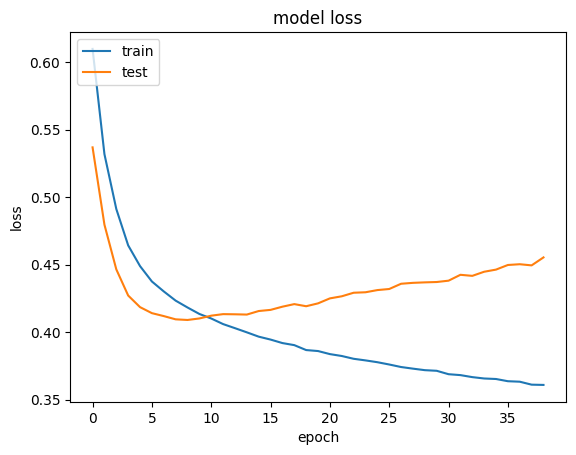

Camadas ocultas: 1
N° neurônios: 64




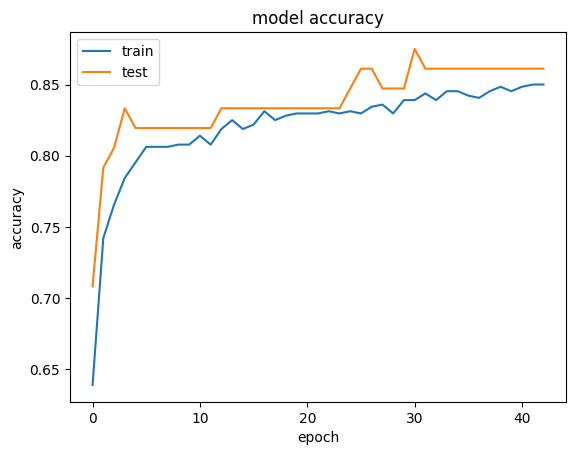

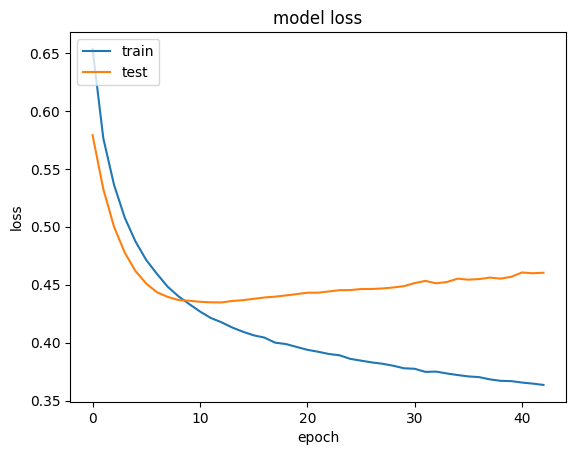

Camadas ocultas: 2
N° neurônios: 16




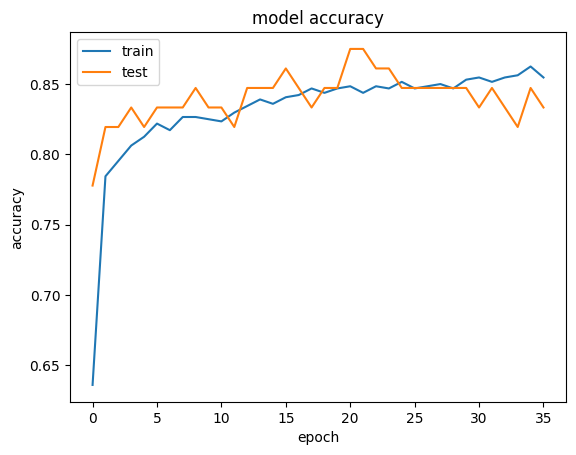

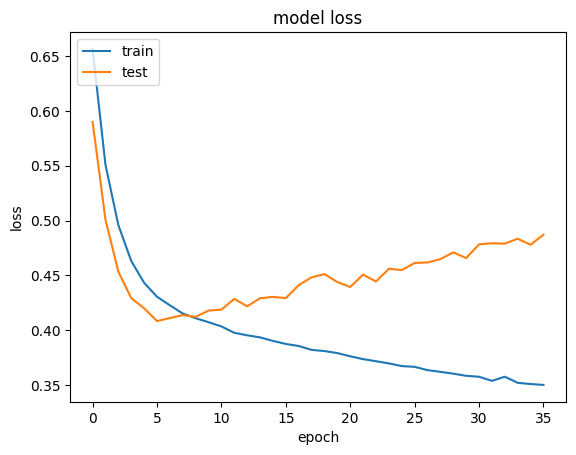

Camadas ocultas: 2
N° neurônios: 32




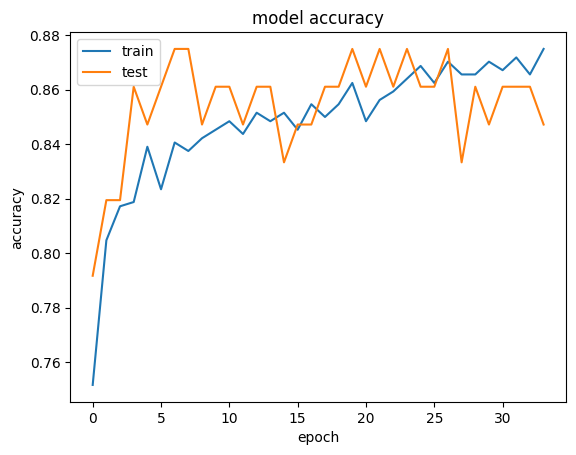

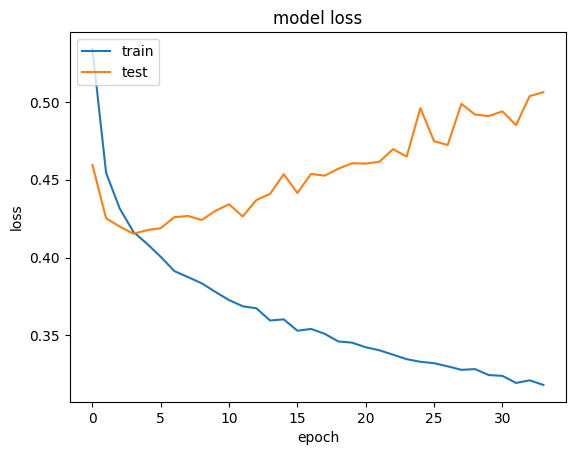

Camadas ocultas: 2
N° neurônios: 64




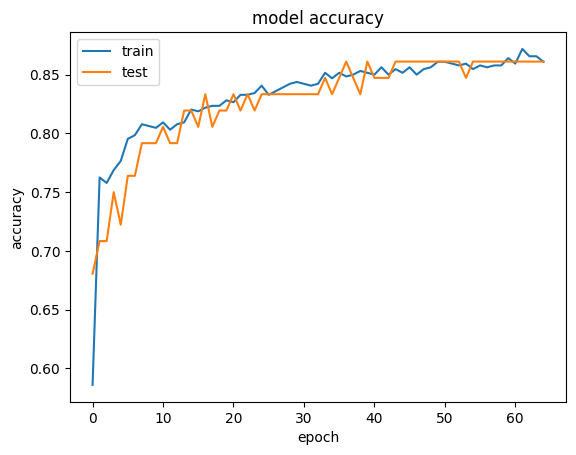

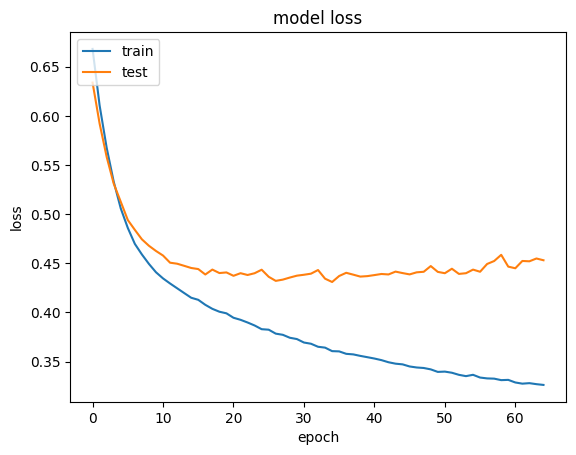

Camadas ocultas: 3
N° neurônios: 16




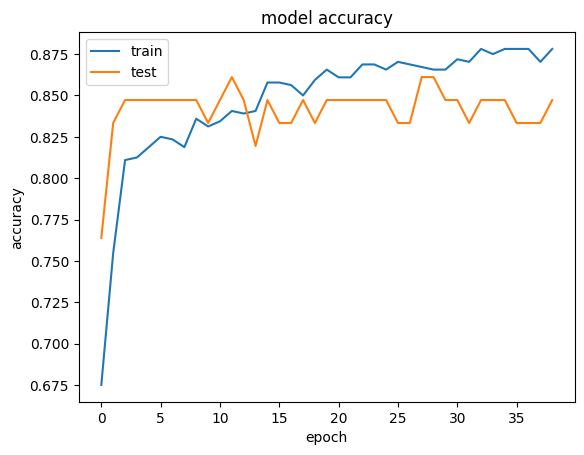

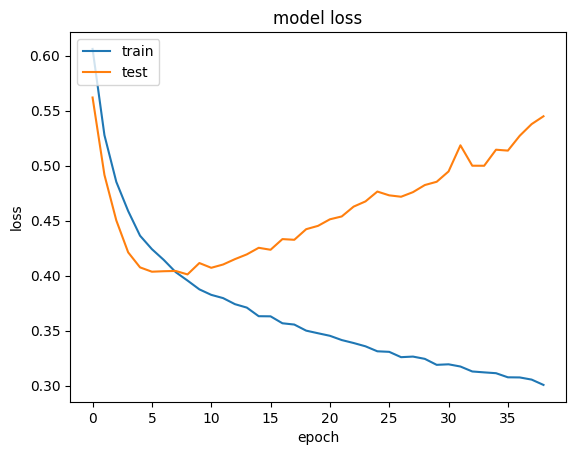

Camadas ocultas: 3
N° neurônios: 32




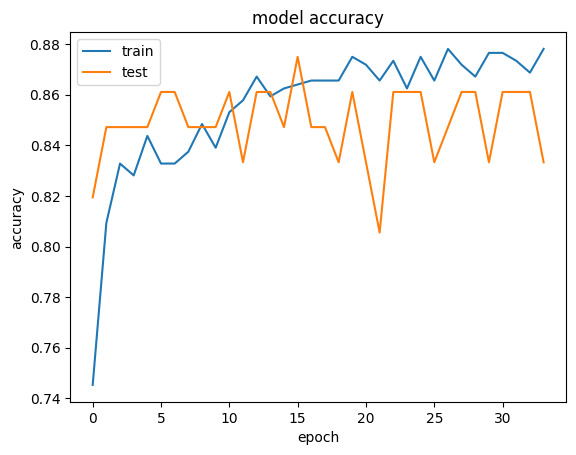

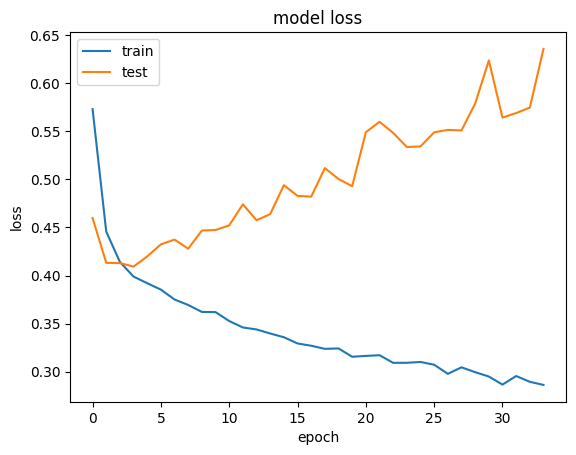

Camadas ocultas: 3
N° neurônios: 64




In [70]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

maxAcc = float('-inf')
bestNLayers = 1
bestNNeuron = 1


for nLayers in [1, 2, 3]:
    for nNeuron in [16, 32, 64]:
        inter = 0
        layersList = []
        while inter < nLayers:
            layersList.append(layers.Dense(nNeuron, activation="relu"))
            inter += 1
        layersList.append(layers.Dense(2, activation="softmax"))

        model = keras.Sequential(layersList)
        model.compile(optimizer="rmsprop" , loss="sparse_categorical_crossentropy"  , metrics=["accuracy", "top_k_categorical_accuracy"])
        
        history = model.fit(x=X_train_std, y=y_train, epochs=160, callbacks=[callback], validation_split=0.1, verbose=0)

        # Obtendo os hyperparâmetros do melhor modelo
        if np.mean(history.history['val_accuracy']) > maxAcc:
            bestNLayers = nLayers
            bestNNeuron = nNeuron

        # Printando as infomações:
        # Histórico de precisão:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # Histórico de perdas:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        print(f'Camadas ocultas: {nLayers}\nN° neurônios: {nNeuron}\n\n')

### Avaliando o melhor modelo

In [81]:
inter = 0
layersList = []
while inter < bestNLayers:
    layersList.append(layers.Dense(bestNNeuron, activation="relu"))
    inter += 1
layersList.append(layers.Dense(2, activation="softmax"))

model = keras.Sequential(layersList)
model.compile(optimizer="rmsprop" , loss="sparse_categorical_crossentropy"  , metrics=["accuracy", "top_k_categorical_accuracy"])
model.fit(x=X_train_std, y=y_train, epochs=160, callbacks=[callback], validation_split=0.1, verbose=0)

In [82]:
test_loss, test_acc, test_topk = model.evaluate(X_test_std,y_test)
print(f'\nTest Loss: {round(test_loss * 100, 2)}%')
print(f'Test Acc: {round(test_acc * 100, 2)}%')
print(f'Test Top K: {round(test_topk * 100, 2)}%')

6/6 [==============================] - 0s 5ms/step - loss: 0.5328 - accuracy: 0.8045 - top_k_categorical_accuracy: 1.0000

Test Loss: 53.28%
Test Acc: 80.45%
Test Top K: 100.0%
